# Modeling

In [133]:
#import libaries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_val_predict
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error, r2_score

In [134]:
# import data
df = pd.read_csv("train.csv")

#remove outliers
df = df.sort_values("log_price")[:-5]

# shuffle
df = df.sample(frac=1)

df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,long,sqft_living15,sqft_lot15,log_price,log_sqft_above,log_sqft_living,log_sqft_living15,log_sqft_lot,log_sqft_lot15,mean_log_price_zip
14926,379000.0,4,1.75,2180,7876,1.0,0,0,4,7,...,-122.191,1960,7225,12.845291,7.162397,7.687080,7.580700,8.971575,8.885303,12.852321
10863,224000.0,3,1.50,1440,8370,1.0,0,0,3,7,...,-122.275,1440,8370,12.319401,7.272398,7.272398,7.272398,9.032409,9.032409,12.844956
14688,635000.0,4,2.50,2970,7961,1.0,0,0,3,8,...,-122.290,1410,7959,13.361380,7.610853,7.996317,7.251345,8.982310,8.982059,13.008593
6457,250000.0,4,2.50,1800,8100,2.0,0,0,3,7,...,-122.047,1590,8100,12.429216,7.495542,7.495542,7.371489,8.999619,8.999619,12.761279
762,410000.0,5,2.50,2670,184140,1.0,0,0,3,8,...,-122.097,1860,35719,12.923912,7.251345,7.889834,7.528332,12.123452,10.483438,12.597284


# 1.1 Select Features

To select the best features I will use the absolute value of pearson's correlation with the log of price. I will not use any two columns together if they have an absolute correlation over 0.6.

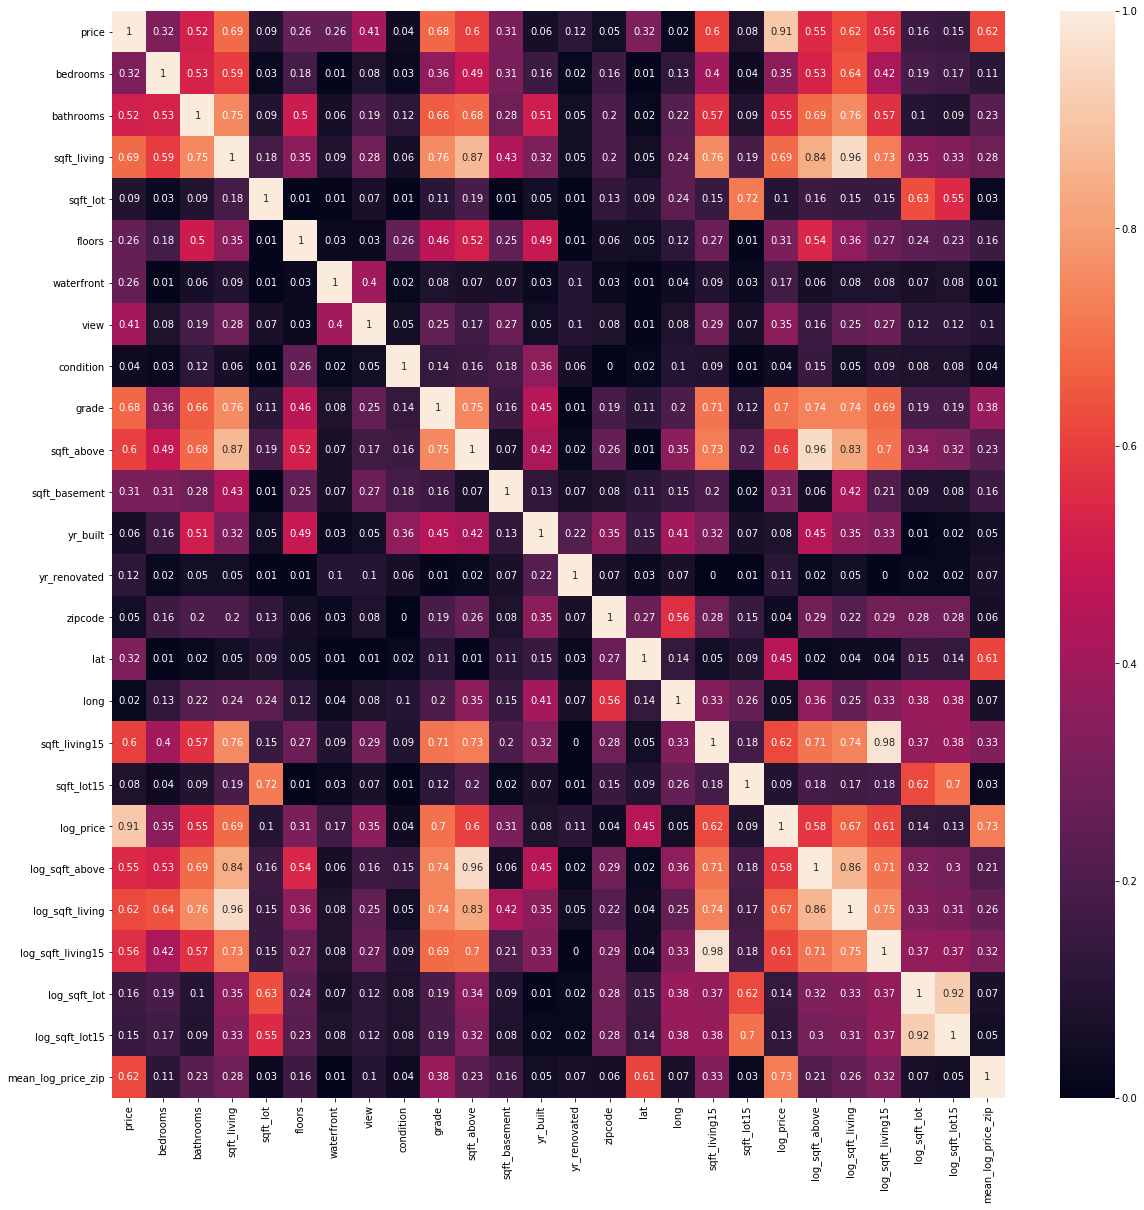

In [135]:
# plot absolute correlations
plt.figure(figsize=(20, 20))
sns.heatmap(round(abs(df.corr()), 2), annot=True)
plt.show()

The best columns are sqft_living and grade, and mean_log_price_zip. A problem arises where grade and sqft_living are correlated so I will try them both out for good measure. Note that since the grade had such a clear linear relationship, I am deciding not to use one-hot-encoding.

# 1.2 Preprocessing

Now I will seperate the data into X and y sets, as well as scale the data with standardization.

In [136]:
X = df[["sqft_living", "grade", "mean_log_price_zip"]]
y = df["log_price"]

sc = StandardScaler()
X = sc.fit_transform(X)

# 1.3 Linear Regression

I will use ridge regression with different combinations of features and see which are the best. Then I will tune the regularization hyperparameter to see if that can improve the results.

# RFE

It seems that using sqft_living and the mean_log_price_zipcode features returned the best results. Let's try adjusting the hyperparameters (regularization) to see if we can fine tune the model.

In [97]:
# take grade out of X
X = X[:, [1, -1]]

In [98]:
# try searching for better alpha (regularization) values
gs = GridSearchCV(ridge, {"alpha":[0.1, 0.5, 1, 2, 10]}, cv=5, scoring="neg_mean_squared_error")
gs.fit(X, y)
# find best alpha
print(gs.best_params_)
# print score
print(gs.best_score_)

{'alpha': 2}
-0.05831945759466741


In [131]:
# try searching for better alpha (regularization) values
gs = GridSearchCV(ridge, {"alpha":[2, 3, 4, 5, 6, 7]}, cv=5, scoring="neg_mean_squared_error")
gs.fit(X, y)
# find best alpha
print(gs.best_params_)
# print score
print(gs.best_score_)

{'alpha': 5}
-0.05361417239513009


It seems like an alpha of 3 will work well. The score did not change much, but a higher alpha level will reduce the chances of overfitting

Now I will check that the errors are normally distributed and that there is no heteroskedascicity (change in variance of errors). I will also convert the log-scaled price back to regular dollars.

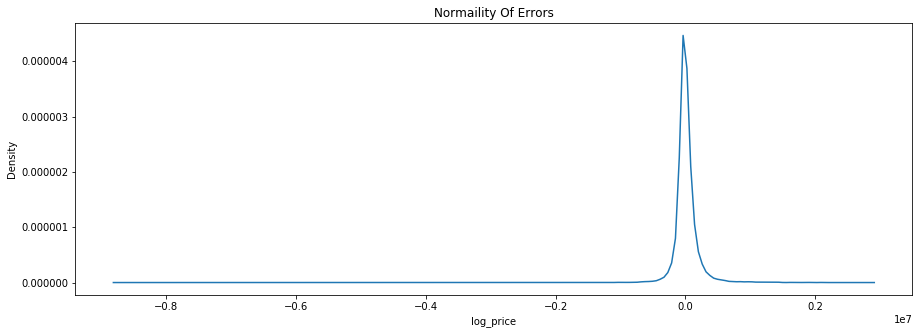

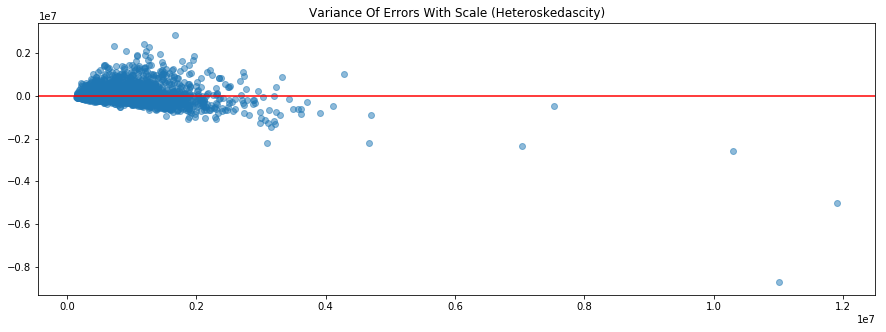

In [132]:
ridge = gs.best_estimator_

# take exp to convert back to dollars
y = np.exp(y)
y_hat = np.exp(ridge.predict(X))

errors = y - y_hat

# plot for normality
plt.figure(figsize=(15, 5))
sns.kdeplot(errors)
plt.title("Normaility Of Errors")
plt.show()

# plot for heteroskedascity
plt.figure(figsize=(15, 5))
plt.scatter(y_hat, errors, alpha=0.5)
plt.axhline(errors.mean(), color="red")
plt.title("Variance Of Errors With Scale (Heteroskedascity)")
plt.show()

It seems the model holds up well until the price gets extremely large.

## Interpreting Results

Now it is time to interpret the model. First let's take a look at the R-squared

In [126]:
r2_score(y, y_hat)

0.550873494324907

The R-squared value indicates that the log of the price is approximately %55 related to the mean zipcode log price and the sqft living space. In other words atleast %45 is not predictable with this model and these features. Next let's look at the accuracy of the model with root mean squared error and absolute mean error.

In [ ]:
# find rmse

The second thing to look at is the coefficients. These are hard to interpret on their own as they are relative to the feature. I will show an example of how much a standard deviation of added living space might do to a houses price.

In [117]:
# print coefficients
if "grade" in feats:
    feats.remove(grade)
print(dict(zip(feats, ridge.coef_)))

{'sqft_living': 0.2806003810230018, 'mean_log_price_zip': 0.30435783356493906}


In [118]:
# print the standard deviation for living space
df["sqft_living"].std()

916.6734426806632

In [119]:
# print mean house price
y.mean()

13.049380082470044

So if the living area of a house was increased by 916 sqft and the house was at average price in the beggining. The increase in price could look something like this.

In [121]:
np.exp(1*ridge.coef_[0]+y.mean()) - np.exp(y.mean())

150562.7259753205

According to the model there would be a $ 150,500 increase in price.